# Fine-tuning Test with FineTuner

This notebook demonstrates simplified fine-tuning using the `FineTuner` class.
Uses 3000 high-confidence PSMs for both training and evaluation.


## 1. Setup and Imports


In [17]:
%reload_ext autoreload
%autoreload 2
from alpharaw import register_all_readers
from dia_aspire_rescore.io import read_diann2
import matplotlib.pyplot as plt
from dia_aspire_rescore.psm.matcher import DIAPeptideSpectrumMatcher
from dia_aspire_rescore.config import FineTuneConfig
from dia_aspire_rescore.finetuning import FineTuner
from peptdeep.model.ms2 import calc_ms2_similarity
import warnings
from pathlib import Path
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
register_all_readers()



## 2. Load, Filter and Sample Data


In [18]:
psm_df_all = read_diann2("../data/raw/SYS026_RA957/DDA_SYSMHC_bynam/lib-base-result-first-pass.parquet")
psm_df_filtered = psm_df_all[psm_df_all['fdr1_search1'] < 0.01].copy()
psm_df_sample = psm_df_filtered.sort_values(by='nAA', ascending=True).reset_index(drop=True)

## 3. Match MS2 Spectra


In [19]:
matcher = DIAPeptideSpectrumMatcher(n_neighbors=0)

ms_files = {
    '20200317_QE_HFX2_LC3_DIA_RA957_R01': './output/20200317_QE_HFX2_LC3_DIA_RA957_R01.mzML.hdf5',
    '20200317_QE_HFX2_LC3_DIA_RA957_R02': './output/20200317_QE_HFX2_LC3_DIA_RA957_R02.mzML.hdf5'
}

psm_df, fragment_mz_df, matched_intensity_df, matched_mz_err_df = matcher.match_ms2_multi_raw(
    psm_df_sample,
    ms_files,
    'hdf5'
)

100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


In [20]:
psm_df_sample

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,fdr1_search1,fdr2_search1,fdr1_search2,fdr2_search2,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs
0,20200317_QE_HFX2_LC3_DIA_RA957_R02,FRPDNFVF,2,95.554832,95.400719,95.738922,0.0,1/sp|Q13885|TBB2A_HUMAN,1/sp|Q13885|TBB2A_HUMAN,,...,3.204689e-03,0.000124,0.0,0.0,,,8,0.799000,521.261259,0.0
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHINQPAL,1,74.619064,74.434471,74.741615,0.0,1/sp|Q8NBU5|ATAD1_HUMAN,1/sp|Q8NBU5|ATAD1_HUMAN,,...,1.618712e-04,0.000124,0.0,0.0,,,8,0.623474,939.504677,0.0
2,20200317_QE_HFX2_LC3_DIA_RA957_R02,LPAFGHVL,2,91.256973,91.133316,91.412209,0.0,1/sp|Q9H7P9|PKHG2_HUMAN,1/sp|Q9H7P9|PKHG2_HUMAN,,...,2.237220e-04,0.000124,0.0,0.0,,,8,0.763063,427.250163,0.0
3,20200317_QE_HFX2_LC3_DIA_RA957_R02,FHEPTTIL,2,75.891342,75.799294,76.044533,0.0,1/sp|A0AUZ9|KAL1L_HUMAN,1/sp|A0AUZ9|KAL1L_HUMAN,,...,6.289933e-04,0.000124,0.0,0.0,,,8,0.634580,479.255643,0.0
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHEPTTIL,2,75.828842,75.706223,76.012619,0.0,1/sp|A0AUZ9|KAL1L_HUMAN,1/sp|A0AUZ9|KAL1L_HUMAN,,...,6.289933e-04,0.000124,0.0,0.0,,,8,0.633582,479.255643,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83140,20200317_QE_HFX2_LC3_DIA_RA957_R01,DVINAAEKLQVVGR,2,79.252640,79.160156,79.375626,0.0,1/sp|O43175|SERA_HUMAN,1/sp|O43175|SERA_HUMAN,,...,4.727965e-07,0.000124,0.0,0.0,,,14,0.662190,756.430647,0.0
83141,20200317_QE_HFX2_LC3_DIA_RA957_R02,DVINAAEKLQVVGR,2,79.286400,79.163261,79.378700,0.0,1/sp|O43175|SERA_HUMAN,1/sp|O43175|SERA_HUMAN,,...,4.727965e-07,0.000124,0.0,0.0,,,14,0.662969,756.430647,0.0
83142,20200317_QE_HFX2_LC3_DIA_RA957_R01,NTFEIHDDIEVLKR,3,75.803810,75.650566,75.895706,0.0,2/sp|Q14186|TFDP1_HUMAN/sp|Q14188|TFDP2_HUMAN,2/sp|Q14186|TFDP1_HUMAN/sp|Q14188|TFDP2_HUMAN,,...,5.419384e-07,0.000124,0.0,0.0,,,14,0.633373,576.968693,0.0
83143,20200317_QE_HFX2_LC3_DIA_RA957_R02,AAQPTATSPVVYTR,2,55.960728,55.775856,56.052738,0.0,1/sp|P49790|NU153_HUMAN,1/sp|P49790|NU153_HUMAN,,...,8.692251e-05,0.000124,0.0,0.0,,,14,0.467926,731.388448,0.0


## 4. Create and Save Configuration


In [21]:
# Create configuration
config = FineTuneConfig(
    instrument='QE',
    nce=27,
    psm_num_to_train_ms2=3000,
    epoch_to_train_ms2=20,
    psm_num_to_train_rt_ccs=3000,
    epoch_to_train_rt_ccs=20,
    train_verbose=True,
    thread_num=8
)


output_dir = Path('../tests/test_data/finetuning')
output_dir.mkdir(parents=True, exist_ok=True)
config.to_yaml(str(output_dir / 'config.yaml'))
print("\nConfiguration:")
for key, value in config.to_dict().items():
    print(f"  {key}: {value}")



Configuration:
  instrument: QE
  nce: 27
  mask_modloss: True
  device: None
  psm_num_to_train_ms2: 3000
  psm_num_to_test_ms2: 0
  epoch_to_train_ms2: 20
  warmup_epoch_to_train_ms2: 10
  batch_size_to_train_ms2: 512
  lr_to_train_ms2: 0.0001
  psm_num_per_mod_to_train_ms2: 50
  top_n_mods_to_train: 10
  psm_num_to_train_rt_ccs: 3000
  epoch_to_train_rt_ccs: 20
  warmup_epoch_to_train_rt_ccs: 10
  batch_size_to_train_rt_ccs: 1024
  lr_to_train_rt_ccs: 0.0001
  psm_num_per_mod_to_train_rt_ccs: 50
  train_verbose: True
  thread_num: 8


## 5. RT Fine-tuning


In [22]:
# Initialize FineTuner
finetuner = FineTuner(config)
finetuner.load_pretrained('generic')

In [23]:
# Prepare RT evaluation data (group by peptide sequence)
psm_df_rt = psm_df.groupby(['sequence', 'mods', 'mod_sites'])[['rt_norm']].median().reset_index()
print(f"Unique peptides for RT: {len(psm_df_rt)}")

# Evaluate BEFORE fine-tuning
print("\n" + "=" * 70)
print("RT Model - BEFORE Fine-tuning")
print("=" * 70)

rt_test_before = finetuner.test_rt_model(psm_df_rt)
print("\nTest statistics:")
print(rt_test_before)

psm_df_rt_pred_before = finetuner.predict_rt(psm_df_rt.copy())
rt_errors_before = (psm_df_rt_pred_before['rt_pred'] - psm_df_rt_pred_before['rt_norm']).abs()
print(f"\nPrediction errors:")
print(f"  MAE: {rt_errors_before.mean():.4f}")
print(f"  Median: {rt_errors_before.median():.4f}")
print(f"  R_square: {rt_test_before['R_square'].values[0]:.4f}")


Unique peptides for RT: 33166

RT Model - BEFORE Fine-tuning

Test statistics:
   R_square         R     slope  intercept  test_num
0  0.966628  0.983172  0.957532    0.15358     33166
2025-11-22 05:15:23> Predicting RT ...


100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


Prediction errors:
  MAE: 0.1401
  Median: 0.1378
  R_square: 0.9666


In [24]:
print("\n" + "=" * 70)
print("Fine-tuning RT Model...")
print("=" * 70)
finetuner.train_rt(psm_df)


Fine-tuning RT Model...
2025-11-22 05:15:26> 3103 PSMs for RT model training/transfer learning
2025-11-22 05:15:26> Training with fixed sequence length: 0
[Training] Epoch=1, lr=2e-05, loss=0.13450338784605265
[Training] Epoch=2, lr=3e-05, loss=0.13174815103411674
[Training] Epoch=3, lr=4e-05, loss=0.12681996077299118
[Training] Epoch=4, lr=5e-05, loss=0.12054217886179686
[Training] Epoch=5, lr=6e-05, loss=0.11211033072322607
[Training] Epoch=6, lr=7e-05, loss=0.10141199082136154
[Training] Epoch=7, lr=8e-05, loss=0.0895564891397953
[Training] Epoch=8, lr=9e-05, loss=0.07476869178935885
[Training] Epoch=9, lr=0.0001, loss=0.059063723077997565
[Training] Epoch=10, lr=0.0001, loss=0.0442240284755826
[Training] Epoch=11, lr=9.755282581475769e-05, loss=0.03622019104659557
[Training] Epoch=12, lr=9.045084971874738e-05, loss=0.03202300239354372
[Training] Epoch=13, lr=7.938926261462366e-05, loss=0.028533499920740724
[Training] Epoch=14, lr=6.545084971874738e-05, loss=0.02618830348365009
[Tr

In [25]:
# Evaluate AFTER fine-tuning
print("\n" + "=" * 70)
print("RT Model - AFTER Fine-tuning")
print("=" * 70)

rt_test_after = finetuner.test_rt_model(psm_df_rt)
print("\nTest statistics:")
print(rt_test_after)

psm_df_rt_pred_after = finetuner.predict_rt(psm_df_rt.copy())
rt_errors_after = (psm_df_rt_pred_after['rt_pred'] - psm_df_rt_pred_after['rt_norm']).abs()
print(f"\nPrediction errors:")
print(f"  MAE: {rt_errors_after.mean():.4f}")
print(f"  Median: {rt_errors_after.median():.4f}")
print(f"  R_square: {rt_test_after['R_square'].values[0]:.4f}")

# Improvement
print("\n" + "=" * 70)
print("RT Improvement")
print("=" * 70)
print(f"MAE: {rt_errors_before.mean():.4f} -> {rt_errors_after.mean():.4f} (Δ: {rt_errors_after.mean() - rt_errors_before.mean():+.4f})")
print(f"R_square: {rt_test_before['R_square'].values[0]:.4f} -> {rt_test_after['R_square'].values[0]:.4f}")



RT Model - AFTER Fine-tuning

Test statistics:
   R_square         R     slope  intercept  test_num
0  0.974679  0.987258  0.974965   0.023202     33166
2025-11-22 05:15:46> Predicting RT ...


100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


Prediction errors:
  MAE: 0.0253
  Median: 0.0179
  R_square: 0.9747

RT Improvement
MAE: 0.1401 -> 0.0253 (Δ: -0.1148)
R_square: 0.9666 -> 0.9747


## 6. MS2 Fine-tuning


In [28]:
# Predict MS2 BEFORE fine-tuning
print("\n" + "=" * 70)
print("MS2 Model - BEFORE Fine-tuning")
print("=" * 70)

psm_df_ms2_before = psm_df.copy()
intensity_before = finetuner.predict_ms2(psm_df_ms2_before.sort_values(by='nAA', ascending=True).reset_index(drop=True))

intensity_before


MS2 Model - BEFORE Fine-tuning
2025-11-22 05:16:56> Predicting MS2 ...


100%|██████████| 7/7 [00:26<00:00,  3.76s/it]


,b_z1,b_z2,y_z1,y_z2
0,0.000000,0.0,0.017934,0.0
1,1.000000,0.0,0.000000,0.0
2,0.574841,0.0,0.000000,0.0
3,0.270515,0.0,0.015329,0.0
4,0.503213,0.0,0.263847,0.0
...,...,...,...,...
709486,0.000000,0.0,1.000000,0.0
709487,0.000000,0.0,0.086405,0.0
709488,0.000000,0.0,0.212852,0.0
709489,0.000000,0.0,0.179970,0.0


In [26]:
psm_df

,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,fdr2_search2,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs,frag_start_idx,frag_stop_idx,spec_idx
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHINQPAL,1,74.619064,74.434471,74.741615,0.0,1/sp|Q8NBU5|ATAD1_HUMAN,1/sp|Q8NBU5|ATAD1_HUMAN,,...,0.0,,,8,0.623474,939.504677,0.0,7,14,55266
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHEPTTIL,2,75.828842,75.706223,76.012619,0.0,1/sp|A0AUZ9|KAL1L_HUMAN,1/sp|A0AUZ9|KAL1L_HUMAN,,...,0.0,,,8,0.633582,479.255643,0.0,28,35,56171
2,20200317_QE_HFX2_LC3_DIA_RA957_R01,FHESGHAL,2,29.155046,29.061045,29.280382,0.0,1/sp|Q9UQ90|SPG7_HUMAN,1/sp|Q9UQ90|SPG7_HUMAN,,...,0.0,,,8,0.243603,449.214309,0.0,42,49,21394
3,20200317_QE_HFX2_LC3_DIA_RA957_R01,YHSETLEL,2,65.168007,64.983940,65.290543,0.0,1/sp|O43314|VIP2_HUMAN,1/sp|O43314|VIP2_HUMAN,,...,0.0,,,8,0.544506,496.240190,0.0,56,63,48168
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,TTGPQVKR,2,17.724962,17.630938,17.817862,0.0,1/sp|Q86VM9|ZCH18_HUMAN,1/sp|Q86VM9|ZCH18_HUMAN,,...,0.0,,,8,0.148100,443.758884,0.0,63,70,13022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83140,20200317_QE_HFX2_LC3_DIA_RA957_R02,FTAFLPDSTGSFTR,2,97.970245,97.847168,98.093941,0.0,1/sp|P19838|NFKB1_HUMAN,1/sp|P19838|NFKB1_HUMAN,,...,0.0,,,14,0.819197,773.880455,0.0,709374,709387,72582
83141,20200317_QE_HFX2_LC3_DIA_RA957_R02,DVINAAEKLQVVGR,3,79.305840,79.182716,79.428864,0.0,1/sp|O43175|SERA_HUMAN,1/sp|O43175|SERA_HUMAN,,...,0.0,,,14,0.663131,504.622857,0.0,709413,709426,58634
83142,20200317_QE_HFX2_LC3_DIA_RA957_R02,DVINAAEKLQVVGR,2,79.286400,79.163261,79.378700,0.0,1/sp|O43175|SERA_HUMAN,1/sp|O43175|SERA_HUMAN,,...,0.0,,,14,0.662969,756.430647,0.0,709439,709452,58621
83143,20200317_QE_HFX2_LC3_DIA_RA957_R02,AAQPTATSPVVYTR,2,55.960728,55.775856,56.052738,0.0,1/sp|P49790|NU153_HUMAN,1/sp|P49790|NU153_HUMAN,,...,0.0,,,14,0.467926,731.388448,0.0,709465,709478,41232


In [ ]:
psm_df

In [29]:
psm_df_ms2_before, metrics_before = calc_ms2_similarity(
    psm_df_ms2_before,
    intensity_before,
    matched_intensity_df,
    metrics=['PCC', 'COS', 'SA', 'SPC']
)

print("\nMS2 Similarity Metrics (Before):")
print(metrics_before)

print("\nTarget PSMs mean:")
target_before = psm_df_ms2_before[psm_df_ms2_before['decoy'] == 0]
for metric in ['PCC', 'COS', 'SA', 'SPC']:
    print(f"  {metric}: {target_before[metric].mean():.4f}")


MS2 Similarity Metrics (Before):
                PCC           COS            SA           SPC
count  83145.000000  83145.000000  83145.000000  83145.000000
mean       0.164213      0.301910      0.202588     -0.255139
std        0.249403      0.214074      0.153457      0.430509
min       -0.316125      0.000000      0.000000     -1.824780
25%       -0.038060      0.123760      0.078991     -0.560117
50%        0.108213      0.259513      0.167124     -0.228185
75%        0.326397      0.447611      0.295450      0.067449
max        0.986268      0.986394      0.894862      0.997434
>0.90      0.001948      0.003187      0.000000      0.000168
>0.75      0.021565      0.034855      0.001371      0.001672

Target PSMs mean:
  PCC: 0.1646
  COS: 0.3025
  SA: 0.2030
  SPC: -0.2544


In [12]:
# Fine-tune MS2 model
finetuner.train_ms2(psm_df, matched_intensity_df)


2025-11-22 04:57:04> 3135 PSMs for MS2 model training/transfer learning
2025-11-22 04:57:04> Training with fixed sequence length: 0
[Training] Epoch=1, lr=2e-05, loss=0.08022019944407723
[Training] Epoch=2, lr=3e-05, loss=0.07558064433661374
[Training] Epoch=3, lr=4e-05, loss=0.07062018594958565
[Training] Epoch=4, lr=5e-05, loss=0.06665004722096703
[Training] Epoch=5, lr=6e-05, loss=0.06318177384409038
[Training] Epoch=6, lr=7e-05, loss=0.06080147725614635
[Training] Epoch=7, lr=8e-05, loss=0.05921643836931749
[Training] Epoch=8, lr=9e-05, loss=0.05736065926876935
[Training] Epoch=9, lr=0.0001, loss=0.05540540204806761
[Training] Epoch=10, lr=0.0001, loss=0.054986352947625244
[Training] Epoch=11, lr=9.755282581475769e-05, loss=0.05350588058883494
[Training] Epoch=12, lr=9.045084971874738e-05, loss=0.053088637576861816
[Training] Epoch=13, lr=7.938926261462366e-05, loss=0.051411943340843376
[Training] Epoch=14, lr=6.545084971874738e-05, loss=0.05157086659561504
[Training] Epoch=15, lr=

In [13]:
# Predict MS2 AFTER fine-tuning
print("\n" + "=" * 70)
print("MS2 Model - AFTER Fine-tuning")
print("=" * 70)

psm_df_ms2_after = psm_df_sample.copy()
intensity_after = finetuner.predict_ms2(psm_df_ms2_after)

# Calculate similarity metrics
psm_df_ms2_after, metrics_after = calc_ms2_similarity(
    psm_df_ms2_after,
    intensity_after,
    matched_intensity_df,
    charged_frag_types=None,
    metrics=['PCC', 'COS', 'SA', 'SPC']
)

print("\nMS2 Similarity Metrics (After):")
print(metrics_after)

print("\nTarget PSMs mean:")
target_after = psm_df_ms2_after[psm_df_ms2_after['decoy'] == 0]
for metric in ['PCC', 'COS', 'SA', 'SPC']:
    print(f"  {metric}: {target_after[metric].mean():.4f}")

# Improvement
print("\n" + "=" * 70)
print("MS2 Improvement")
print("=" * 70)
for metric in ['PCC', 'COS', 'SA', 'SPC']:
    before_val = target_before[metric].mean()
    after_val = target_after[metric].mean()
    print(f"{metric}: {before_val:.4f} -> {after_val:.4f} (Δ: {after_val - before_val:+.4f})")

intensity_after


MS2 Model - AFTER Fine-tuning
2025-11-22 04:58:12> Predicting MS2 ...


100%|██████████| 7/7 [00:22<00:00,  3.28s/it]



MS2 Similarity Metrics (After):
                PCC           COS            SA           SPC
count  83145.000000  83145.000000  83145.000000  83145.000000
mean       0.778049      0.810387      0.668210      0.515095
std        0.269092      0.234514      0.242137      0.302837
min       -0.249037      0.000000      0.000000     -1.338343
25%        0.666729      0.722468      0.513985      0.359238
50%        0.906257      0.921501      0.746073      0.576963
75%        0.974105      0.977696      0.865291      0.734106
max        0.999876      0.999880      0.990126      1.000000
>0.90      0.512274      0.547886      0.149883      0.050707
>0.75      0.692826      0.728847      0.493860      0.226171

Target PSMs mean:
  PCC: 0.7830
  COS: 0.8148
  SA: 0.6723
  SPC: 0.5208

MS2 Improvement
PCC: 0.6254 -> 0.7830 (Δ: +0.1576)
COS: 0.6856 -> 0.8148 (Δ: +0.1292)
SA: 0.5165 -> 0.6723 (Δ: +0.1558)
SPC: 0.3413 -> 0.5208 (Δ: +0.1795)


,b_z1,b_z2,y_z1,y_z2
0,0.000000,0.00000,0.000000,0.0
1,0.074211,0.00000,0.000000,0.0
2,0.000000,0.00000,0.000000,0.0
3,0.085158,0.00000,0.000000,0.0
4,0.427742,0.00699,0.000000,0.0
...,...,...,...,...
709486,0.000000,0.00000,0.335720,0.0
709487,0.000000,0.00000,0.034539,0.0
709488,0.000000,0.00000,0.089055,0.0
709489,0.000000,0.00000,0.068245,0.0


## 7. Save Test Data


In [14]:
# Save all data
print("Saving test data to:", output_dir)

psm_df.to_parquet(output_dir / 'psm_df.parquet', index=False)
print(f"✓ psm_df.parquet ({len(psm_df):,} rows)")

matched_intensity_df.to_parquet(output_dir / 'matched_intensity.parquet')
print(f"✓ matched_intensity.parquet {matched_intensity_df.shape}")

fragment_mz_df.to_parquet(output_dir / 'fragment_mz_df.parquet')
print(f"✓ fragment_mz_df.parquet {fragment_mz_df.shape}")



Saving test data to: ../tests/test_data/finetuning
✓ psm_df.parquet (83,145 rows)
✓ matched_intensity.parquet (709491, 4)
✓ fragment_mz_df.parquet (709491, 4)


## 8. Visualization


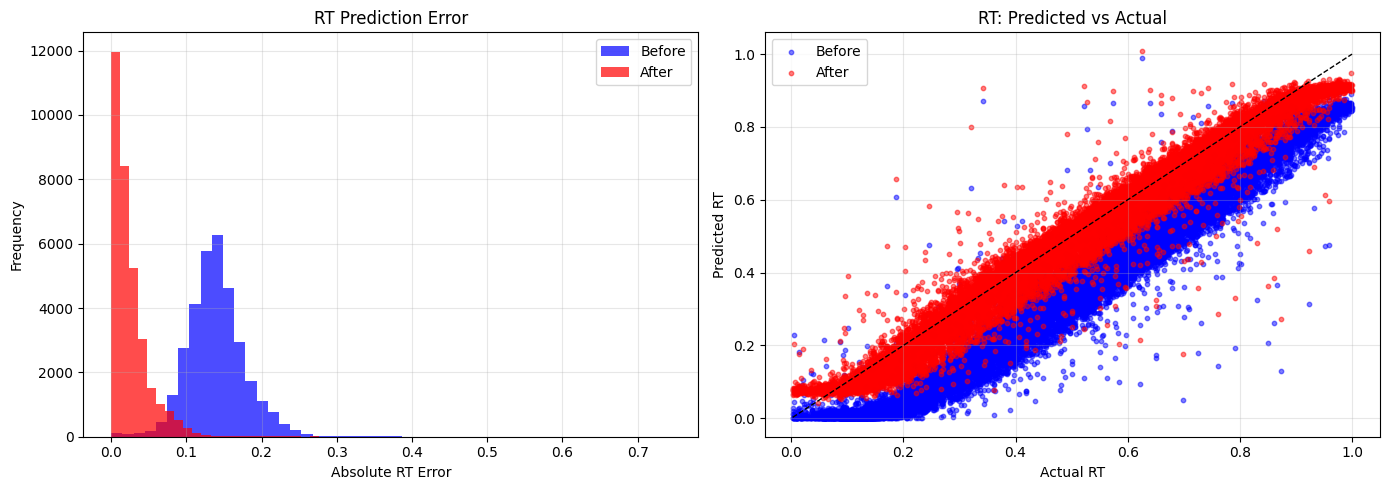

In [15]:
# RT comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(rt_errors_before, bins=50, alpha=0.7, label='Before', color='blue')
axes[0].hist(rt_errors_after, bins=50, alpha=0.7, label='After', color='red')
axes[0].set_xlabel('Absolute RT Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title('RT Prediction Error')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(psm_df_rt_pred_before['rt_norm'], psm_df_rt_pred_before['rt_pred'], 
                alpha=0.5, s=10, label='Before', color='blue')
axes[1].scatter(psm_df_rt_pred_after['rt_norm'], psm_df_rt_pred_after['rt_pred'], 
                alpha=0.5, s=10, label='After', color='red')
axes[1].plot([psm_df_rt['rt_norm'].min(), psm_df_rt['rt_norm'].max()],
             [psm_df_rt['rt_norm'].min(), psm_df_rt['rt_norm'].max()],
             'k--', linewidth=1)
axes[1].set_xlabel('Actual RT')
axes[1].set_ylabel('Predicted RT')
axes[1].set_title('RT: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


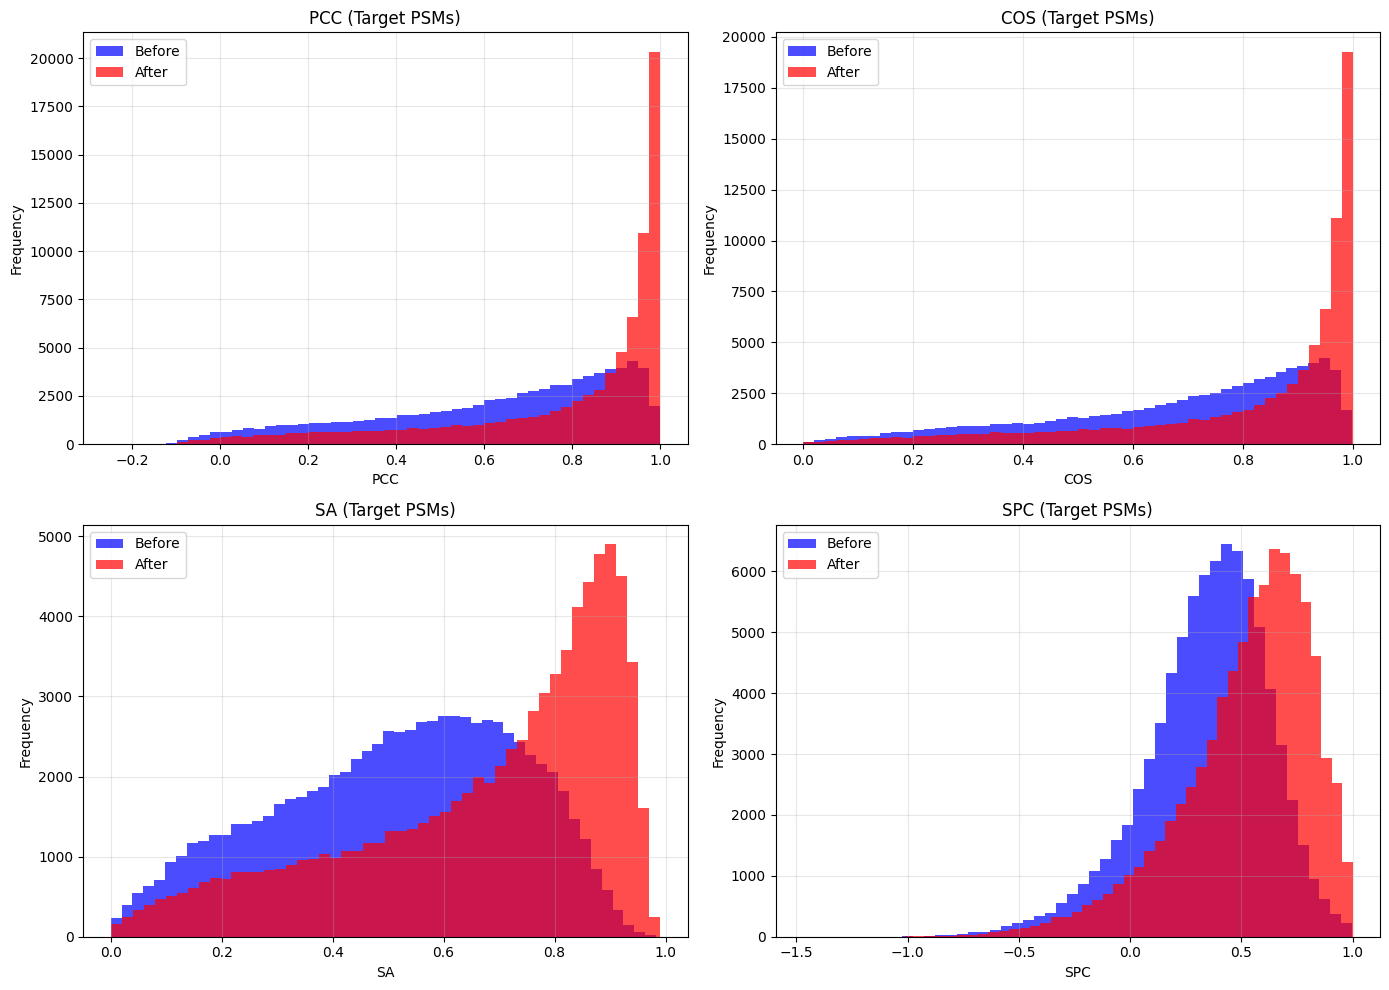

In [16]:
# MS2 comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, metric in enumerate(['PCC', 'COS', 'SA', 'SPC']):
    ax = axes[idx // 2, idx % 2]
    
    before_vals = target_before[metric].values
    after_vals = target_after[metric].values
    
    ax.hist(before_vals, bins=50, alpha=0.7, label='Before', color='blue')
    ax.hist(after_vals, bins=50, alpha=0.7, label='After', color='red')
    ax.set_xlabel(metric)
    ax.set_ylabel('Frequency')
    ax.set_title(f'{metric} (Target PSMs)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
